## Diamond Analysis Pt5 (actually 4)
### Analyze and Retrain w/ BlueNile Data Only

A few things happened
1.  I found out that all these diamond datasets are either dated or fictious on the web
2.  Cross testing across datasets yielded poor predictions mainly because the data was quite different in pricing
3.  I was able to hack thru the problems downloading bluenile data by running in a time-delayed fetch so now I have 100k+ of market priced diamonds w/ good attribution (round cut only is 140k rows which is majority of inventory overall)

So now the approach is stick w/ bluenile data.  I pulled the entire lot of Round cut diamonds which is 50k+ rows.   We can start w/ that as the baseline dataset.  I do want to combine w/ Tiffany's and other luxury diamond dealers to understand how premium name brands affect pricing.

 
### Step 1 Load and Clean up

In [94]:
# loading important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import myutils 
 
# Loading the data
diamonds5 = pd.read_csv('./blue-nile-download-round-full.csv')
print(diamonds5.shape)
print(diamonds5.describe())
print(diamonds5.columns)

diamonds5.head()

(141458, 27)
       imageUrl         price   sellingIndex
count       0.0  1.414580e+05  141458.000000
mean        NaN  4.599543e+03       0.375252
std         NaN  1.933595e+04       0.150851
min         NaN  2.810000e+02       0.000029
25%         NaN  5.870000e+02       0.288981
50%         NaN  1.248000e+03       0.376647
75%         NaN  3.271000e+03       0.463128
max         NaN  2.055533e+06       0.962772
Index(['carat', 'clarity', 'color', 'culet', 'cut', 'date', 'dateSet', 'depth',
       'detailsPageUrl', 'fluorescence', 'hasVisualization', 'id', 'imageUrl',
       'lxwRatio', 'measurements', 'polish', 'price', 'pricePerCarat',
       'sellingIndex', 'shapeCode', 'shapeName', 'skus', 'symmetry', 'table',
       'v360BaseUrl', 'visualizationImageUrl', 'willArriveForHoliday'],
      dtype='object')


,carat,clarity,color,culet,cut,date,dateSet,depth,detailsPageUrl,fluorescence,...,pricePerCarat,sellingIndex,shapeCode,shapeName,skus,symmetry,table,v360BaseUrl,visualizationImageUrl,willArriveForHoliday
0,['0.23'],['FL'],['D'],['None'],"[{'label': 'Ideal', 'labelSmall': 'Ideal'}]",['Sep 30'],['Oct 1'],['58.8'],./diamond-details/LD12750672,['None'],...,"['$3,787']",0.734835,['RD'],['Round'],['LD12750672'],['Excellent'],['60.0'],https://bluenile.v360.in/50/imaged/gia-7313767...,https://bnsec.bluenile.com/bnsecure/diamondvis...,False
1,['0.23'],['FL'],['D'],['None'],"[{'label': 'Ideal', 'labelSmall': 'Ideal'}]",['Sep 30'],['Oct 1'],['59.6'],./diamond-details/LD12389454,['None'],...,"['$3,743']",0.521523,['RD'],['Round'],['LD12389454'],['Excellent'],['59.0'],https://bluenile.v360.in/50/imaged/gia-7316836...,https://bnsec.bluenile.com/bnsecure/diamondvis...,False
2,['0.23'],['FL'],['D'],['None'],"[{'label': 'Ideal', 'labelSmall': 'Ideal'}]",['Sep 30'],['Oct 1'],['59.7'],./diamond-details/LD12750664,['None'],...,"['$3,765']",0.518767,['RD'],['Round'],['LD12750664'],['Excellent'],['60.0'],https://bluenile.v360.in/50/imaged/gia-2316863...,https://bnsec.bluenile.com/bnsecure/diamondvis...,False
3,['0.23'],['FL'],['D'],['None'],"[{'label': 'Ideal', 'labelSmall': 'Ideal'}]",['Sep 30'],['Oct 1'],['59.8'],./diamond-details/LD12505728,['None'],...,"['$3,630']",0.649935,['RD'],['Round'],['LD12505728'],['Excellent'],['59.0'],https://bluenile.v360.in/19/imaged/gia-6322878...,https://bnsec.bluenile.com/bnsecure/diamondvis...,False
4,['0.23'],['FL'],['D'],['None'],"[{'label': 'Ideal', 'labelSmall': 'Ideal'}]",['Sep 30'],['Oct 1'],['60.1'],./diamond-details/LD12505726,['None'],...,"['$3,630']",0.411232,['RD'],['Round'],['LD12505726'],['Excellent'],['59.0'],https://bluenile.v360.in/19/imaged/gia-6321890...,https://bnsec.bluenile.com/bnsecure/diamondvis...,False


In [95]:
# clean up fields
diamonds5a = diamonds5.copy()
diamonds5a.loc[:,'carat'] = diamonds5a.loc[:,'carat'].to_frame().applymap(myutils.cleanBracketsToF)
diamonds5a.loc[:,'clarity'] = diamonds5a.loc[:,'clarity'].to_frame().applymap(myutils.cleanBracketsToS)
diamonds5a.loc[:,'color'] = diamonds5a.loc[:,'color'].to_frame().applymap(myutils.cleanBracketsToS)
diamonds5a.loc[:,'cut'] = diamonds5a.loc[:,'cut'].to_frame().applymap(myutils.cleanCut)
diamonds5a.loc[:,'skus'] = diamonds5a.loc[:,'skus'].to_frame().applymap(myutils.cleanBracketsToS)

# clear nulls
pd.set_option('use_inf_as_na', True)

diamonds5a = diamonds5a.loc[~diamonds5a['carat'].isnull()]  
diamonds5a = diamonds5a.loc[~diamonds5a['price'].isnull()]  
diamonds5a = diamonds5a[['carat','color','cut','clarity','price','skus']]
diamonds5a.sample(n=5,random_state=11 )

# print(diamonds5.iloc[32320:32321]['price'])   # price 713 
# print(diamonds5a.iloc[32320:32321])  # price 713

,carat,color,cut,clarity,price,skus
14465,0.30,I,Ideal,SI2,362,LD11384817
21579,0.30,J,Ideal,VVS1,462,LD12502136
57231,0.41,D,Ideal,SI1,867,LD12530429
119118,1.01,G,Ideal,VS2,6800,LD12877187
11613,0.30,D,Ideal,SI2,491,LD11285594


In [96]:
# drop any nulls
print(diamonds5a.shape)
diamonds5a = diamonds5a.dropna()
print(diamonds5a.shape)


(141458, 6)
(141458, 6)


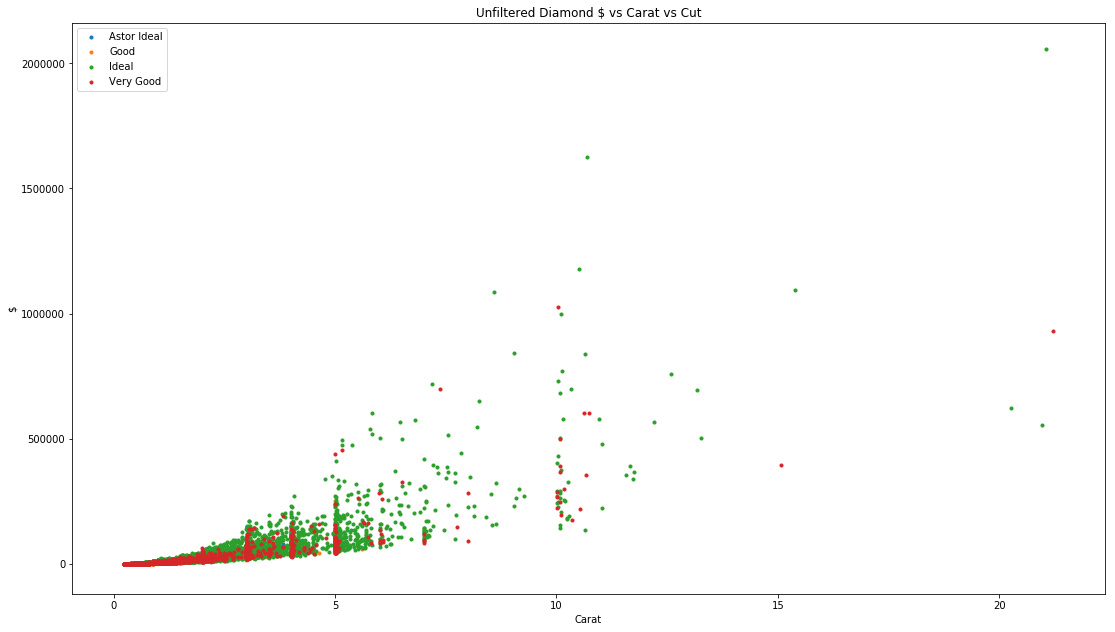

In [97]:
# full dataset
fig, ax = plt.subplots()
for c, df in diamonds5a.groupby('cut'):
    ax.scatter(df['carat'], df['price'], label=c, s=np.pi*3)
ax.legend()
ax.set_title('Unfiltered Diamond $ vs Carat vs Cut')
ax.set_xlabel('Carat')
ax.set_ylabel('$')
fig.set_size_inches(18.5, 10.5)
plt.show()


In [98]:
# narrow down to <= 5 carats since beyond this has alot less data

diamonds5b = diamonds5a.loc[(diamonds5a['carat'] <= 4.5)]
print(diamonds5b.head())

# save this file
# diamonds5b.to_csv('diamonds5b-4c+price-sku.csv')   # save once at least
diamonds5b.describe()


   carat color    cut clarity  price        skus
0   0.23     D  Ideal      FL    871  LD12750672
1   0.23     D  Ideal      FL    861  LD12389454
2   0.23     D  Ideal      FL    866  LD12750664
3   0.23     D  Ideal      FL    835  LD12505728
4   0.23     D  Ideal      FL    835  LD12505726


,carat,price
count,140838.000000,140838.000000
mean,0.658144,3823.331927
std,0.517062,9050.689493
min,0.230000,281.000000
25%,0.330000,586.000000
50%,0.500000,1240.000000
75%,0.780000,3181.000000
max,4.500000,272018.000000


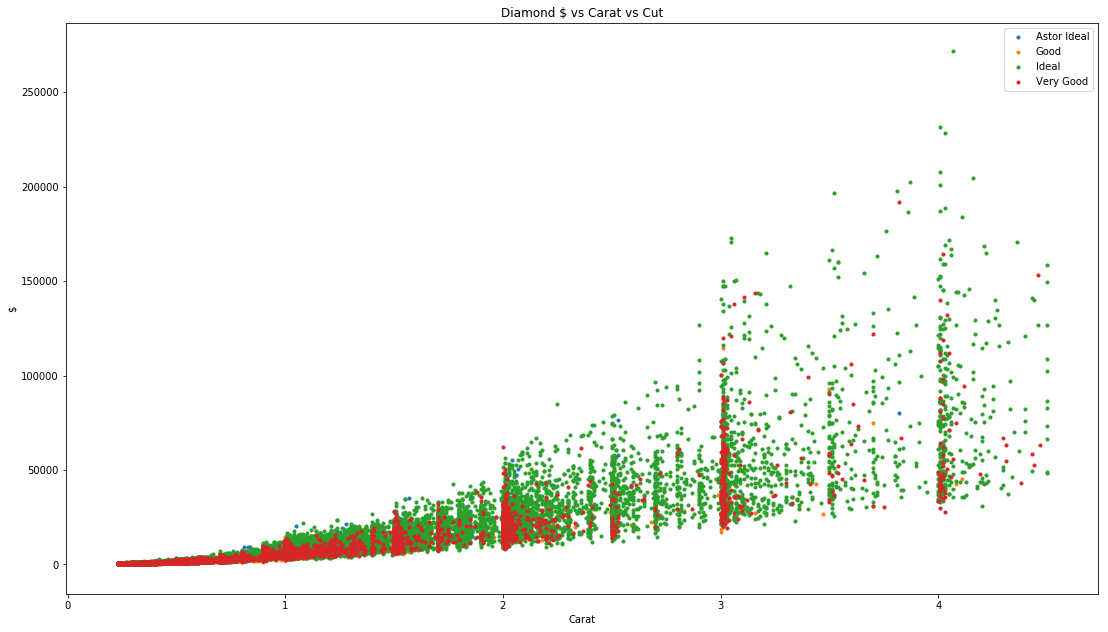

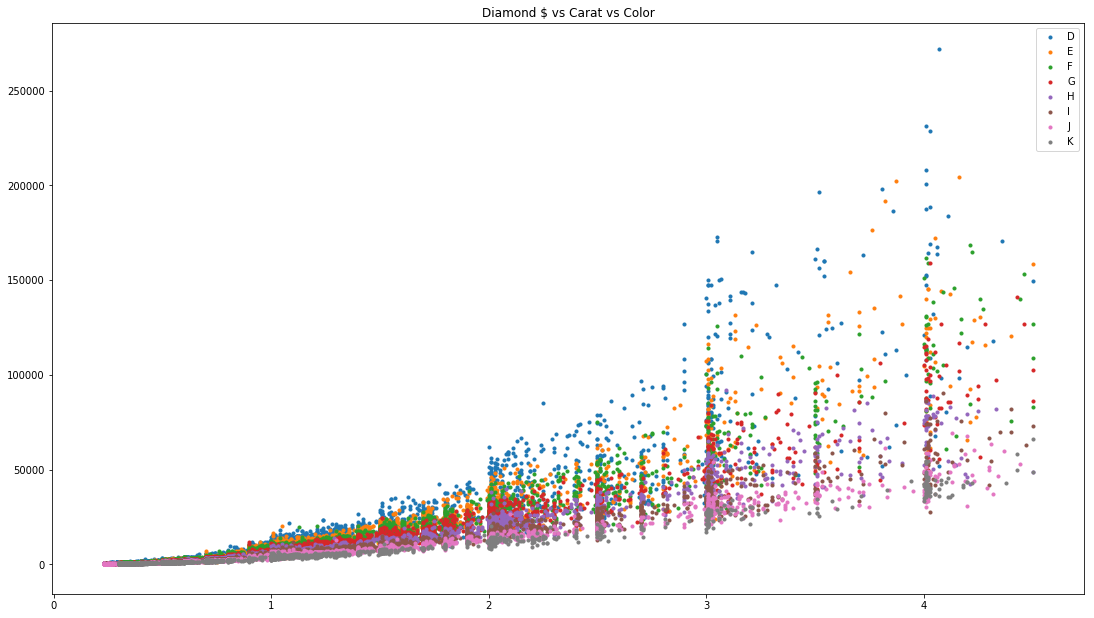

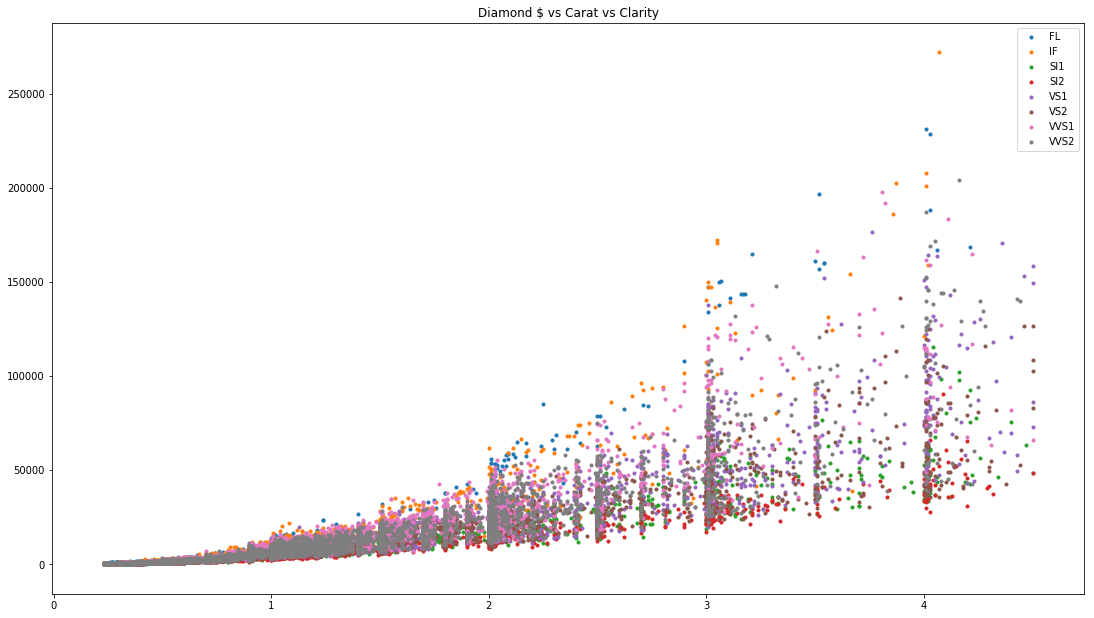

In [99]:
# scatter carat to price
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for c, df in diamonds5b.groupby('cut'):
    ax.scatter(df['carat'], df['price'], label=c, s=np.pi*3)
ax.legend()
ax.set_title('Diamond $ vs Carat vs Cut')
ax.set_xlabel('Carat')
ax.set_ylabel('$')
fig.set_size_inches(18.5, 10.5)
plt.show()

fig, ax = plt.subplots()
for c, df in diamonds5b.groupby('color'):
    ax.scatter(df['carat'], df['price'], label=c, s=np.pi*3)
ax.legend()
ax.set_title('Diamond $ vs Carat vs Color')
fig.set_size_inches(18.5, 10.5)
plt.show()

fig, ax = plt.subplots()
for c, df in diamonds5b.groupby('clarity'):
    ax.scatter(df['carat'], df['price'], label=c, s=np.pi*3)
ax.legend()
ax.set_title('Diamond $ vs Carat vs Clarity')
fig.set_size_inches(18.5, 10.5)
plt.show()



If I have time I will do a correlation analysis across the features.

### OneHot the categoricals and build final diamonds5c set

In [100]:
cut = pd.get_dummies( diamonds5b['cut'], prefix='cut_')
color = pd.get_dummies( diamonds5b['color'], prefix='color_')
clarity = pd.get_dummies( diamonds5b['clarity'], prefix='clarity_')
diamonds5c = diamonds5b[['carat','price','skus']]
diamonds5c = diamonds5c.join(cut).join(color).join(clarity)

assert(len(diamonds5c.loc[diamonds5c['price'].isnull()]) == 0)
print(diamonds5c.sample(n=5, random_state=23).head())
print(diamonds5b['cut'].sample(n=5, random_state=23).head())


       carat  price        skus  cut__Astor Ideal  cut__Good  cut__Ideal  \
10762   0.30    449  LD12365161                 0          0           0   
35894   0.33    969  LD12619994                 0          0           1   
29154   0.31    471  LD12076317                 0          0           1   
11346   0.30    374  LD11077386                 0          1           0   
8026    0.30    472  LD12543246                 0          0           1   

       cut__Very Good  color__D  color__E  color__F  ...  color__J  color__K  \
10762               1         0         0         0  ...         0         0   
35894               0         0         1         0  ...         0         0   
29154               0         0         0         0  ...         1         0   
11346               0         0         0         0  ...         1         0   
8026                0         0         1         0  ...         0         0   

       clarity__FL  clarity__IF  clarity__SI1  clarity__SI2  c

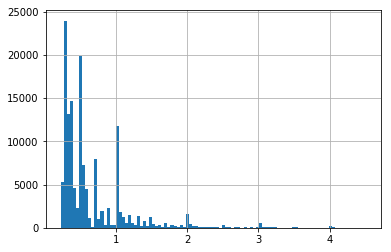

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

diamonds5c['carat'].hist(bins=100)

Text(0, 0.5, 'Number')

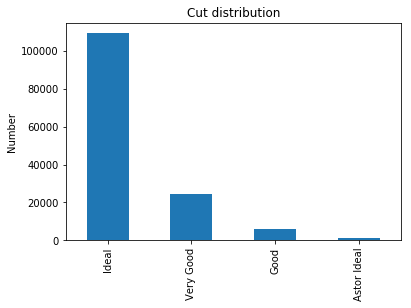

In [102]:
cuts = diamonds5b['cut'].value_counts()
cuts.plot(kind='bar')
plt.title('Cut distribution')
plt.ylabel('Number')

Text(0, 0.5, 'Number')

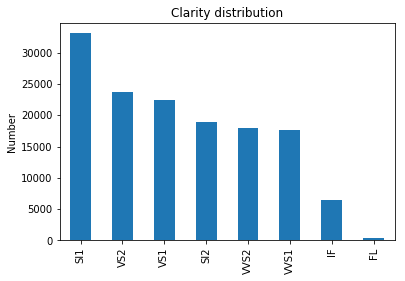

In [103]:
c = diamonds5b['clarity'].value_counts()
c.plot(kind='bar')
plt.title('Clarity distribution')
plt.ylabel('Number')

Text(0, 0.5, 'Number')

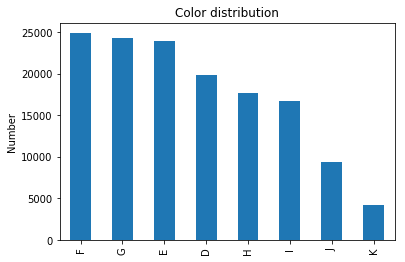

In [104]:
c = diamonds5b['color'].value_counts()
c.plot(kind='bar')
plt.title('Color distribution')
plt.ylabel('Number')

## Normalize/Scale the other input columns (diamonds5d)

In [105]:
from sklearn import preprocessing

assert(len(diamonds5c.loc[diamonds5c['carat'].isnull()]) == 0)

### scale carat->caratScaled
# caratDF = diamonds5c['carat'].to_frame()
# scaler = preprocessing.StandardScaler().fit(caratDF)
# caratDF = pd.DataFrame(scaler.transform(caratDF),columns=['caratScaled'], index=diamonds5c.index)
# diamonds5d = diamonds5c
diamonds5d = diamonds5c
diamonds5d['caratScaled'] = diamonds5d['carat']

# ### normalizing one-hots probably not necessary
# scaler = preprocessing.StandardScaler().fit(diamonds5c.drop(columns=['price']))
# # caratDF = pd.DataFrame(scaler.transform(caratDF),columns=['caratScaled'], index=diamonds5c.index)
# diamonds5d = pd.DataFrame(scaler.transform(diamonds5c.drop(columns=['price'])), 
#                           columns=diamonds5c.drop(columns=['price']).columns, index=diamonds5c.index)
# diamonds5d['price'] = diamonds5c['price']

# print(caratDF.shape)
# print(diamonds5c.shape)
print(diamonds5d.shape)

#diamonds5d = pd.concat([ diamonds5d, caratDF], axis=1)
diamonds5d.to_csv('diamonds5d-4c+price-onehotscaled.csv')
diamonds5d.tail()

(140838, 24)


,carat,price,skus,cut__Astor Ideal,cut__Good,cut__Ideal,cut__Very Good,color__D,color__E,color__F,...,color__K,clarity__FL,clarity__IF,clarity__SI1,clarity__SI2,clarity__VS1,clarity__VS2,clarity__VVS1,clarity__VVS2,caratScaled
140896,4.5,82962,LD12644055,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,4.5
140897,4.5,126878,LD07328378,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,4.5
140898,4.5,108662,LD12825599,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,4.5
140899,4.5,102501,LD12746565,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,4.5
140900,4.5,66129,LD09175452,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,4.5


## Now ready to train a models

We will step thru a few cases
1. Linear using carat only, then color, clarity, cut only
2. Linear using carat + one of the others
3. Linear using carat + two of the others
4. Linear using all 4c's
5. RandomForest using all 4c's
6. XGBoost using all 4c's

In [106]:
from sklearn.model_selection import train_test_split
from myutils import *

train, test = train_test_split(diamonds5d, random_state=12)
train_Y, test_Y = train['price'], test['price']


## Experiments 1a-1d -- single sets of features

Score:  0.7429062134434539


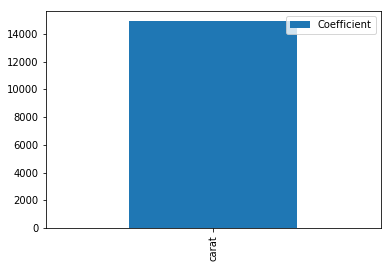

coefficients: [14926.80316553]
intercept: -5993.532236063467
Mean squared error: 19194594.96
R2 Variance score: 0.74
       carat
95968   0.62
18173   0.30
        actual      predict         diff       diff%
95968     2703  3261.085727  -558.085727   20.646901
18173      712 -1515.491286  2227.491286  312.849900
43632      861  -619.883096  1480.883096  171.995714
8241       456 -1515.491286  1971.491286  432.344580
109702    3825  7440.590613 -3615.590613   94.525245
17779      535 -1515.491286  2050.491286  383.269399
39020      691  -918.419160  1609.419160  232.911601
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.00036189539872211185


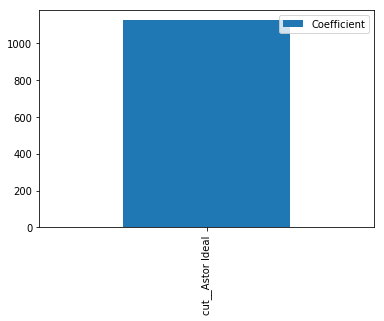

coefficients: [1123.69311131]
intercept: 3831.400099275479
Mean squared error: 74632875.37
R2 Variance score: 0.00
       cut__Astor Ideal
95968                 0
18173                 0
        actual      predict         diff       diff%
95968     2703  3831.400099 -1128.400099   41.746212
18173      712  3831.400099 -3119.400099  438.117991
43632      861  3831.400099 -2970.400099  344.994204
8241       456  3831.400099 -3375.400099  740.219320
109702    3825  3831.400099    -6.400099    0.167323
17779      535  3831.400099 -3296.400099  616.149551
39020      691  3831.400099 -3140.400099  454.471794
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.0005981868746838259


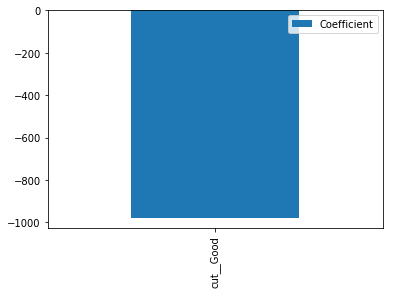

coefficients: [-977.23279555]
intercept: 3881.6850047434627
Mean squared error: 74615233.87
R2 Variance score: 0.00
       cut__Good
95968          0
18173          0
        actual      predict         diff       diff%
95968     2703  3881.685005 -1178.685005   43.606548
18173      712  3881.685005 -3169.685005  445.180478
43632      861  3881.685005 -3020.685005  350.834495
8241       456  3881.685005 -3425.685005  751.246712
109702    3825  3881.685005   -56.685005    1.481961
17779      535  3881.685005 -3346.685005  625.548599
39020      691  3881.685005 -3190.685005  461.748915
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.0011341056509739378


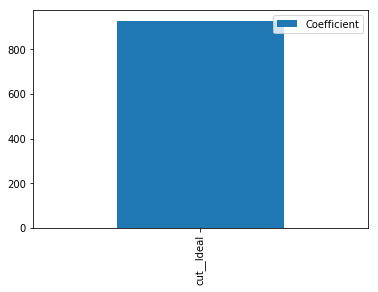

coefficients: [929.57254868]
intercept: 3117.7592182577246
Mean squared error: 74575222.23
R2 Variance score: 0.00
       cut__Ideal
95968           0
18173           0
        actual      predict         diff       diff%
95968     2703  3117.759218  -414.759218   15.344403
18173      712  3117.759218 -2405.759218  337.887531
43632      861  4047.331767 -3186.331767  370.073376
8241       456  4047.331767 -3591.331767  787.572756
109702    3825  3117.759218   707.240782   18.489955
17779      535  4047.331767 -3512.331767  656.510611
39020      691  4047.331767 -3356.331767  485.720950
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.0008231695165885621


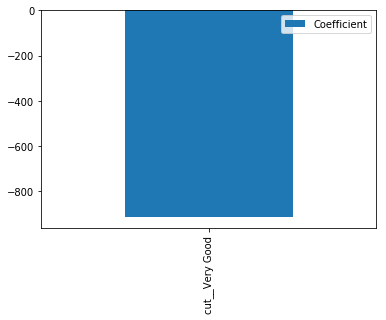

coefficients: [-916.3918796]
intercept: 3998.3767539195073
Mean squared error: 74598436.69
R2 Variance score: 0.00
       cut__Very Good
95968               1
18173               1
        actual      predict         diff       diff%
95968     2703  3081.984874  -378.984874   14.020898
18173      712  3081.984874 -2369.984874  332.863044
43632      861  3998.376754 -3137.376754  364.387544
8241       456  3998.376754 -3542.376754  776.837007
109702    3825  3081.984874   743.015126   19.425232
17779      535  3998.376754 -3463.376754  647.360141
39020      691  3998.376754 -3307.376754  478.636289
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.004363006915469869


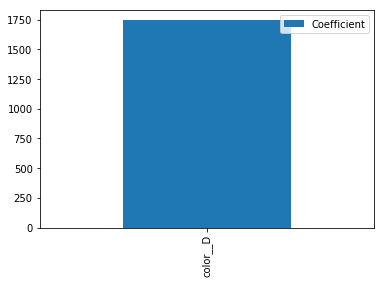

coefficients: [1742.4571395]
intercept: 3594.0270076534866
Mean squared error: 74334152.80
R2 Variance score: 0.00
       color__D
95968         0
18173         0
        actual      predict         diff       diff%
95968     2703  3594.027008  -891.027008   32.964373
18173      712  3594.027008 -2882.027008  404.779074
43632      861  3594.027008 -2733.027008  317.424740
8241       456  3594.027008 -3138.027008  688.163817
109702    3825  3594.027008   230.972992    6.038510
17779      535  3594.027008 -3059.027008  571.780749
39020      691  5336.484147 -4645.484147  672.284247
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  8.549480883968119e-05


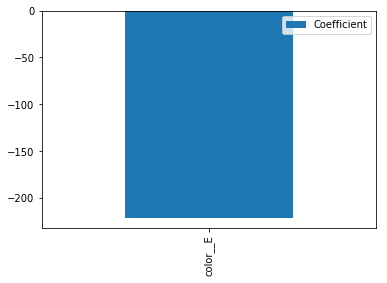

coefficients: [-221.39007504]
intercept: 3878.1348058490353
Mean squared error: 74653511.40
R2 Variance score: 0.00
       color__E
95968         1
18173         1
        actual      predict         diff       diff%
95968     2703  3656.744731  -953.744731   35.284674
18173      712  3656.744731 -2944.744731  413.587743
43632      861  3878.134806 -3017.134806  350.422161
8241       456  3656.744731 -3200.744731  701.917704
109702    3825  3878.134806   -53.134806    1.389145
17779      535  3656.744731 -3121.744731  583.503688
39020      691  3878.134806 -3187.134806  461.235138
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  -0.00019886752646014472


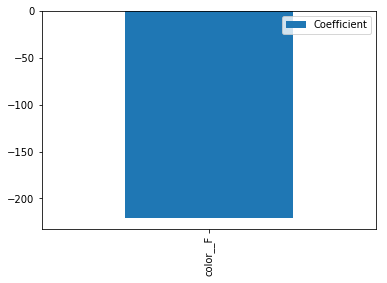

coefficients: [-221.08600654]
intercept: 3879.6489257756334
Mean squared error: 74674741.87
R2 Variance score: -0.00
       color__F
95968         0
18173         0
        actual      predict         diff       diff%
95968     2703  3879.648926 -1176.648926   43.531222
18173      712  3879.648926 -3167.648926  444.894512
43632      861  3879.648926 -3018.648926  350.598017
8241       456  3879.648926 -3423.648926  750.800203
109702    3825  3879.648926   -54.648926    1.428730
17779      535  3879.648926 -3344.648926  625.168024
39020      691  3879.648926 -3188.648926  461.454258
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  1.0033613445981082e-05


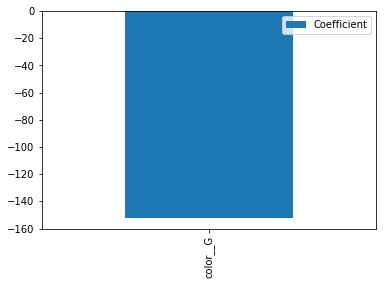

coefficients: [-152.40885665]
intercept: 3866.8287056617996
Mean squared error: 74659145.33
R2 Variance score: 0.00
       color__G
95968         0
18173         0
        actual      predict         diff       diff%
95968     2703  3866.828706 -1163.828706   43.056926
18173      712  3866.828706 -3154.828706  443.093919
43632      861  3866.828706 -3005.828706  349.109025
8241       456  3866.828706 -3410.828706  747.988751
109702    3825  3866.828706   -41.828706    1.093561
17779      535  3866.828706 -3331.828706  622.771721
39020      691  3866.828706 -3175.828706  459.598944
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  -0.00010447400370949822


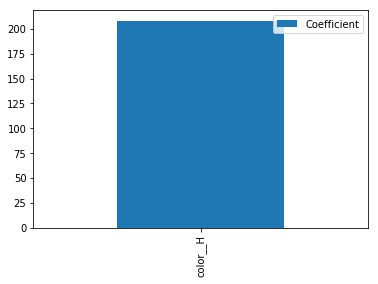

coefficients: [208.09710791]
intercept: 3814.6414328836217
Mean squared error: 74667694.46
R2 Variance score: -0.00
       color__H
95968         0
18173         0
        actual      predict         diff       diff%
95968     2703  3814.641433 -1111.641433   41.126209
18173      712  3814.641433 -3102.641433  435.764246
43632      861  4022.738541 -3161.738541  367.217020
8241       456  3814.641433 -3358.641433  736.544174
109702    3825  3814.641433    10.358567    0.270812
17779      535  3814.641433 -3279.641433  613.017090
39020      691  3814.641433 -3123.641433  452.046517
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.0006992632261206833


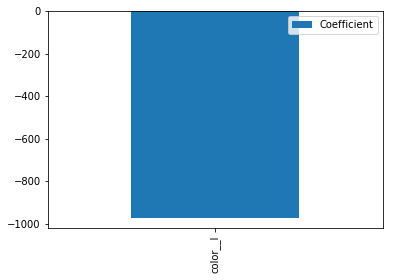

coefficients: [-974.15102912]
intercept: 3956.15613889994
Mean squared error: 74607687.52
R2 Variance score: 0.00
       color__I
95968         0
18173         0
        actual      predict         diff       diff%
95968     2703  3956.156139 -1253.156139   46.361677
18173      712  3956.156139 -3244.156139  455.639907
43632      861  3956.156139 -3095.156139  359.483872
8241       456  3956.156139 -3500.156139  767.578101
109702    3825  2982.005110   842.994890   22.039082
17779      535  3956.156139 -3421.156139  639.468437
39020      691  3956.156139 -3265.156139  472.526214
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.00025000132682473364


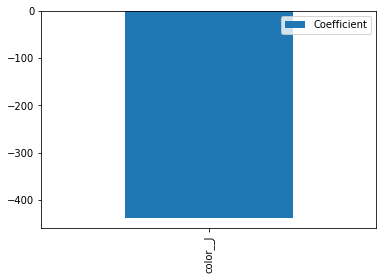

coefficients: [-438.32146787]
intercept: 3870.0409766195808
Mean squared error: 74641229.37
R2 Variance score: 0.00
       color__J
95968         0
18173         0
        actual      predict         diff       diff%
95968     2703  3870.040977 -1167.040977   43.175767
18173      712  3870.040977 -3158.040977  443.545081
43632      861  3870.040977 -3009.040977  349.482111
8241       456  3870.040977 -3414.040977  748.693197
109702    3825  3870.040977   -45.040977    1.177542
17779      535  3870.040977 -3335.040977  623.372145
39020      691  3870.040977 -3179.040977  460.063817
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.00013347221331738712


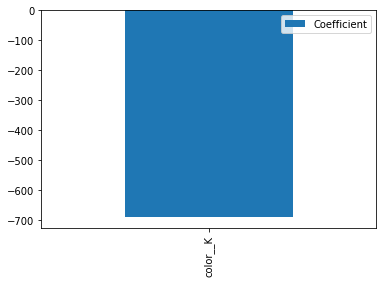

coefficients: [-690.03120879]
intercept: 3861.5557323752505
Mean squared error: 74649929.42
R2 Variance score: 0.00
       color__K
95968         0
18173         0
        actual      predict         diff       diff%
95968     2703  3861.555732 -1158.555732   42.861847
18173      712  3861.555732 -3149.555732  442.353333
43632      861  3861.555732 -3000.555732  348.496601
8241       456  3861.555732 -3405.555732  746.832397
109702    3825  3861.555732   -36.555732    0.955705
17779      535  3861.555732 -3326.555732  621.786118
39020      691  3861.555732 -3170.555732  458.835851
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.004393434200327118


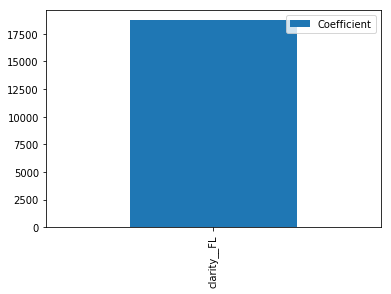

coefficients: [18719.21308592]
intercept: 3782.162671655679
Mean squared error: 74331881.10
R2 Variance score: 0.00
       clarity__FL
95968            0
18173            0
        actual      predict         diff       diff%
95968     2703  3782.162672 -1079.162672   39.924627
18173      712  3782.162672 -3070.162672  431.202622
43632      861  3782.162672 -2921.162672  339.275572
8241       456  3782.162672 -3326.162672  729.421639
109702    3825  3782.162672    42.837328    1.119930
17779      535  3782.162672 -3247.162672  606.946294
39020      691  3782.162672 -3091.162672  447.346262
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.0007998133278726005


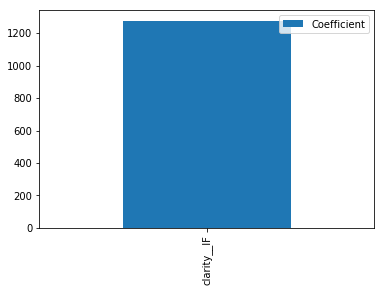

coefficients: [1275.47191807]
intercept: 3782.1527722654387
Mean squared error: 74600180.46
R2 Variance score: 0.00
       clarity__IF
95968            0
18173            0
        actual      predict         diff       diff%
95968     2703  3782.152772 -1079.152772   39.924261
18173      712  3782.152772 -3070.152772  431.201232
43632      861  3782.152772 -2921.152772  339.274422
8241       456  3782.152772 -3326.152772  729.419468
109702    3825  3782.152772    42.847228    1.120189
17779      535  3782.152772 -3247.152772  606.944443
39020      691  3782.152772 -3091.152772  447.344830
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.005147048833626489


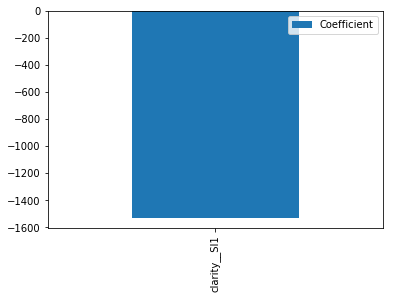

coefficients: [-1531.29406483]
intercept: 4201.56318436307
Mean squared error: 74275616.32
R2 Variance score: 0.01
       clarity__SI1
95968             0
18173             0
        actual      predict         diff       diff%
95968     2703  4201.563184 -1498.563184   55.440739
18173      712  4201.563184 -3489.563184  490.107189
43632      861  4201.563184 -3340.563184  387.986433
8241       456  2670.269120 -2214.269120  485.585333
109702    3825  4201.563184  -376.563184    9.844789
17779      535  4201.563184 -3666.563184  685.338913
39020      691  4201.563184 -3510.563184  508.040982
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.004309058141664157


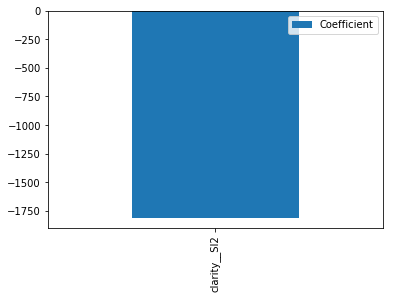

coefficients: [-1809.9995474]
intercept: 4082.5137521445104
Mean squared error: 74338180.61
R2 Variance score: 0.00
       clarity__SI2
95968             0
18173             0
        actual      predict         diff       diff%
95968     2703  4082.513752 -1379.513752   51.036395
18173      712  4082.513752 -3370.513752  473.386763
43632      861  4082.513752 -3221.513752  374.159553
8241       456  4082.513752 -3626.513752  795.288104
109702    3825  4082.513752  -257.513752    6.732386
17779      535  4082.513752 -3547.513752  663.086683
39020      691  4082.513752 -3391.513752  490.812410
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.0028764946355203103


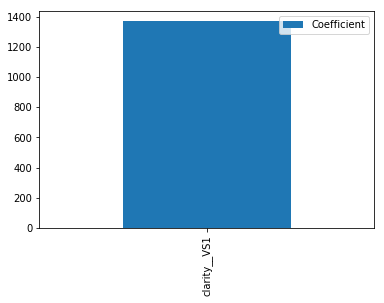

coefficients: [1370.84216214]
intercept: 3621.5497937935393
Mean squared error: 74445135.65
R2 Variance score: 0.00
       clarity__VS1
95968             0
18173             0
        actual      predict         diff       diff%
95968     2703  3621.549794  -918.549794   33.982604
18173      712  3621.549794 -2909.549794  408.644634
43632      861  3621.549794 -2760.549794  320.621347
8241       456  3621.549794 -3165.549794  694.199516
109702    3825  3621.549794   203.450206    5.318960
17779      535  3621.549794 -3086.549794  576.925195
39020      691  3621.549794 -2930.549794  424.102720
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  1.5730247203693537e-06


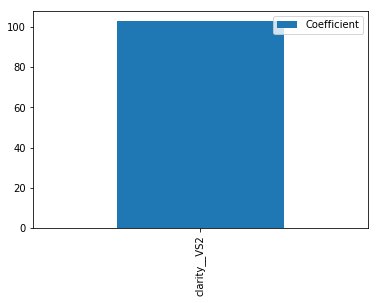

coefficients: [103.05069441]
intercept: 3823.3141445870883
Mean squared error: 74659777.00
R2 Variance score: 0.00
       clarity__VS2
95968             0
18173             1
        actual      predict         diff       diff%
95968     2703  3823.314145 -1120.314145   41.447064
18173      712  3926.364839 -3214.364839  451.455736
43632      861  3823.314145 -2962.314145  344.055069
8241       456  3823.314145 -3367.314145  738.446084
109702    3825  3823.314145     1.685855    0.044075
17779      535  3926.364839 -3391.364839  633.899970
39020      691  3823.314145 -3132.314145  453.301613
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.0008382090888334748


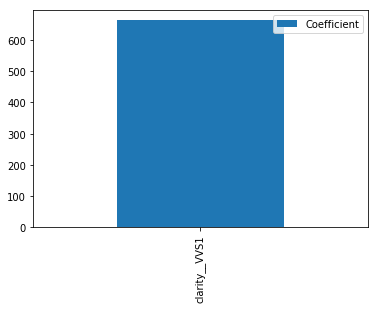

coefficients: [663.84867517]
intercept: 3757.264538062598
Mean squared error: 74597313.84
R2 Variance score: 0.00
       clarity__VVS1
95968              0
18173              0
        actual      predict         diff       diff%
95968     2703  3757.264538 -1054.264538   39.003498
18173      712  3757.264538 -3045.264538  427.705694
43632      861  3757.264538 -2896.264538  336.383802
8241       456  3757.264538 -3301.264538  723.961522
109702    3825  4421.113213  -596.113213   15.584659
17779      535  3757.264538 -3222.264538  602.292437
39020      691  4421.113213 -3730.113213  539.813779
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.0007173589422281301


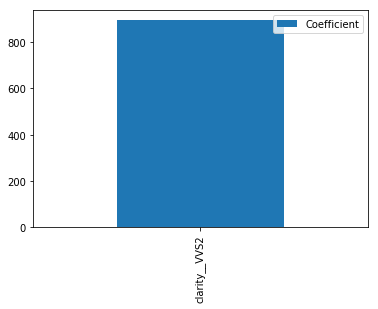

coefficients: [894.39681934]
intercept: 3726.0804903472244
Mean squared error: 74606336.49
R2 Variance score: 0.00
       clarity__VVS2
95968              1
18173              0
        actual     predict        diff       diff%
95968     2703  4620.47731 -1917.47731   70.938857
18173      712  3726.08049 -3014.08049  423.325912
43632      861  4620.47731 -3759.47731  436.640803
8241       456  3726.08049 -3270.08049  717.122915
109702    3825  3726.08049    98.91951    2.586131
17779      535  3726.08049 -3191.08049  596.463643
39020      691  3726.08049 -3035.08049  439.230172
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7429062134434539


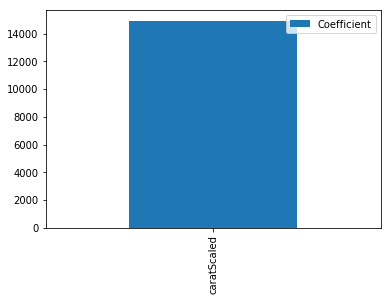

coefficients: [14926.80316553]
intercept: -5993.532236063467
Mean squared error: 19194594.96
R2 Variance score: 0.74
       caratScaled
95968         0.62
18173         0.30
        actual      predict         diff       diff%
95968     2703  3261.085727  -558.085727   20.646901
18173      712 -1515.491286  2227.491286  312.849900
43632      861  -619.883096  1480.883096  171.995714
8241       456 -1515.491286  1971.491286  432.344580
109702    3825  7440.590613 -3615.590613   94.525245
17779      535 -1515.491286  2050.491286  383.269399
39020      691  -918.419160  1609.419160  232.911601
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64


In [107]:
columnSets = ['carat', 'cut__Astor Ideal', 'cut__Good', 'cut__Ideal',
       'cut__Very Good', 'color__D', 'color__E', 'color__F', 'color__G',
       'color__H', 'color__I', 'color__J', 'color__K', 'clarity__FL',
       'clarity__IF', 'clarity__SI1', 'clarity__SI2', 'clarity__VS1',
       'clarity__VS2', 'clarity__VVS1', 'clarity__VVS2', 'caratScaled']

scores = {}
models = {}
for c in columnSets:
    train1 = train[[c]]
    test1 = test[[c]]
    regr, score = run_linear3(train1, train_Y, test1, test_Y, log=True)
    scores[c] = score
    models[c] = regr


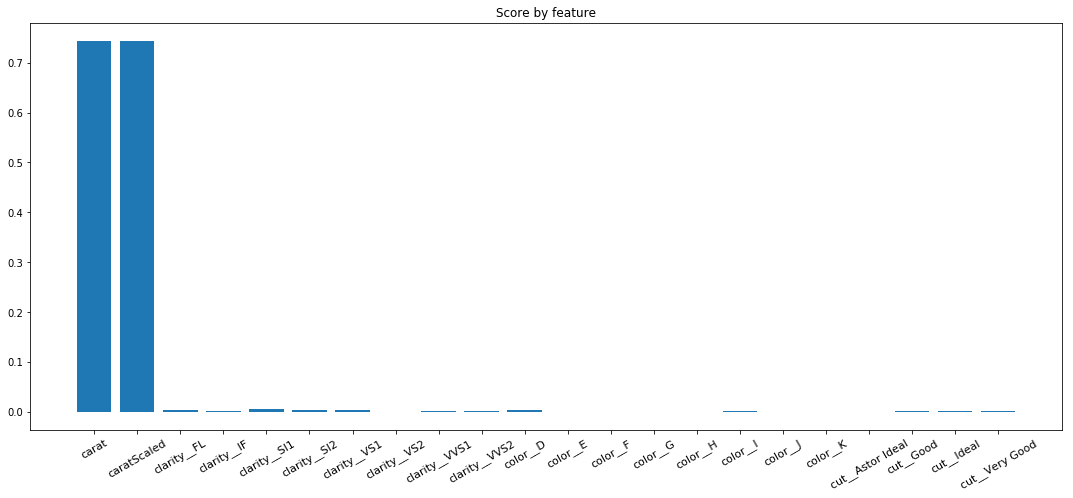

In [108]:
lists = sorted(scores.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_title('Score by feature')
fig.set_size_inches(18.5, 7.5)
plt.xticks(fontsize=11, rotation=30)
plt.show()

## Experiement 2* -- carat ++ features (2-sets)

Score:  0.7429955361707936


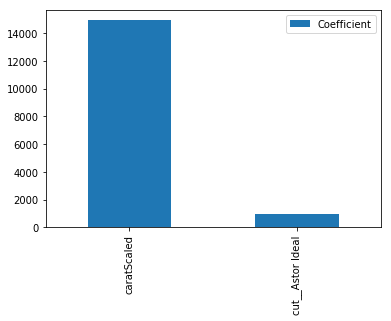

coefficients: [14926.44258629   933.53730358]
intercept: -6000.97487446557
Mean squared error: 19187926.14
R2 Variance score: 0.74
       caratScaled  cut__Astor Ideal
95968         0.62                 0
18173         0.30                 0
        actual      predict         diff       diff%
95968     2703  3253.419529  -550.419529   20.363283
18173      712 -1523.042099  2235.042099  313.910407
43632      861  -627.455543  1488.455543  172.875208
8241       456 -1523.042099  1979.042099  434.000460
109702    3825  7432.823453 -3607.823453   94.322182
17779      535 -1523.042099  2058.042099  384.680766
39020      691  -925.984395  1616.984395  234.006425
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7443742492064784


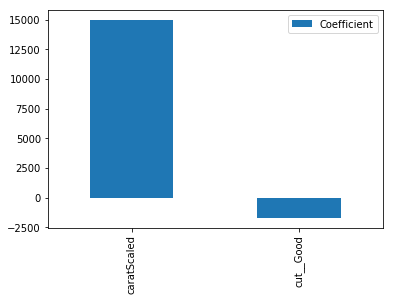

coefficients: [14939.0796106  -1699.19082654]
intercept: -5930.26032007723
Mean squared error: 19084991.57
R2 Variance score: 0.74
       caratScaled  cut__Good
95968         0.62          0
18173         0.30          0
        actual      predict         diff       diff%
95968     2703  3331.969038  -628.969038   23.269295
18173      712 -1448.536437  2160.536437  303.446129
43632      861  -552.191660  1413.191660  164.133758
8241       456 -1448.536437  1904.536437  417.661499
109702    3825  7514.911329 -3689.911329   96.468270
17779      535 -1448.536437  1983.536437  370.754474
39020      691  -850.973252  1541.973252  223.150977
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.744914142480243


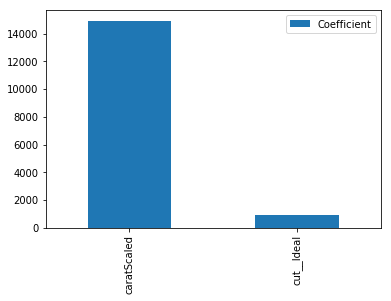

coefficients: [14926.01408647   909.41568526]
intercept: -6700.22279891727
Mean squared error: 19044683.20
R2 Variance score: 0.74
       caratScaled  cut__Ideal
95968         0.62           0
18173         0.30           0
        actual      predict         diff       diff%
95968     2703  2553.905935   149.094065    5.515874
18173      712 -2222.418573  2934.418573  412.137440
43632      861  -417.442043  1278.442043  148.483396
8241       456 -1313.002888  1769.002888  387.939230
109702    3825  6733.189879 -2908.189879   76.031108
17779      535 -1313.002888  1848.002888  345.421101
39020      691  -715.962324  1406.962324  203.612493
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7438687136577595


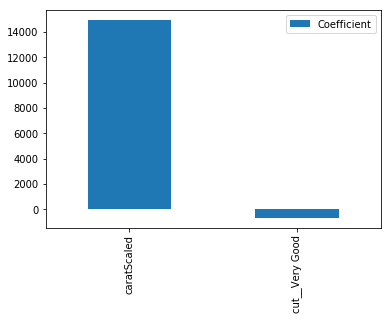

coefficients: [14921.05908119  -677.46392999]
intercept: -5873.140808602946
Mean squared error: 19122734.80
R2 Variance score: 0.74
       caratScaled  cut__Very Good
95968         0.62               1
18173         0.30               1
        actual      predict         diff       diff%
95968     2703  2700.451892     2.548108    0.094270
18173      712 -2074.287014  2786.287014  391.332446
43632      861  -501.559539  1362.559539  158.253140
8241       456 -1396.823084  1852.823084  406.320852
109702    3825  6878.348434 -3053.348434   79.826103
17779      535 -1396.823084  1931.823084  361.088427
39020      691  -799.980721  1490.980721  215.771450
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7462410338373626


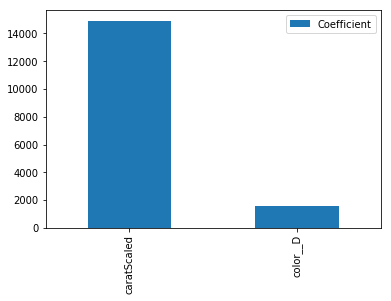

coefficients: [14917.37151441  1540.11887447]
intercept: -6205.298277118922
Mean squared error: 18945617.63
R2 Variance score: 0.75
       caratScaled  color__D
95968         0.62         0
18173         0.30         0
        actual      predict         diff       diff%
95968     2703  3043.472062  -340.472062   12.596081
18173      712 -1730.086823  2442.086823  342.989722
43632      861  -835.044532  1696.044532  196.985428
8241       456 -1730.086823  2186.086823  479.405005
109702    3825  7220.336086 -3395.336086   88.766956
17779      535 -1730.086823  2265.086823  423.380715
39020      691   406.726912   284.273088   41.139376
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7444929517623037


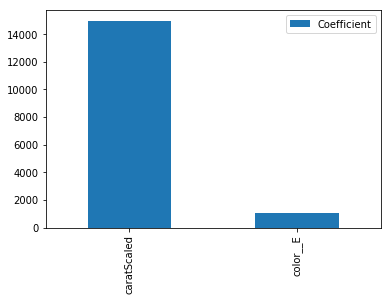

coefficients: [14972.85059849  1043.13134427]
intercept: -6200.512928120972
Mean squared error: 19076129.25
R2 Variance score: 0.74
       caratScaled  color__E
95968         0.62         1
18173         0.30         1
        actual      predict         diff       diff%
95968     2703  4125.785787 -1422.785787   52.637284
18173      712  -665.526404  1377.526404  193.472810
43632      861  -810.286713  1671.286713  194.109955
8241       456  -665.526404  1121.526404  245.948773
109702    3825  7275.052611 -3450.052611   90.197454
17779      535  -665.526404  1200.526404  224.397459
39020      691 -1109.743725  1800.743725  260.599671
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7438902991216385


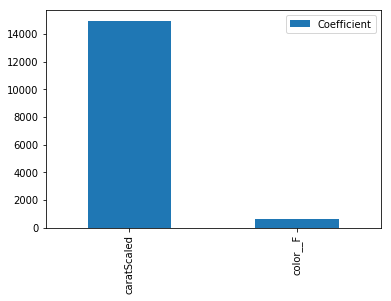

coefficients: [14947.3510831    651.75000729]
intercept: -6122.052157586912
Mean squared error: 19121123.23
R2 Variance score: 0.74
       caratScaled  color__F
95968         0.62         0
18173         0.30         0
        actual      predict         diff       diff%
95968     2703  3145.305514  -442.305514   16.363504
18173      712 -1637.846833  2349.846833  330.034668
43632      861  -741.005768  1602.005768  186.063388
8241       456 -1637.846833  2093.846833  459.176937
109702    3825  7330.563817 -3505.563817   91.648727
17779      535 -1637.846833  2172.846833  406.139595
39020      691 -1039.952789  1730.952789  250.499680
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.743191160828498


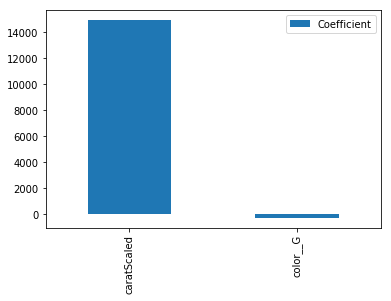

coefficients: [14928.17300943  -287.11737199]
intercept: -5945.107663423945
Mean squared error: 19173320.82
R2 Variance score: 0.74
       caratScaled  color__G
95968         0.62         0
18173         0.30         0
        actual      predict         diff       diff%
95968     2703  3310.359602  -607.359602   22.469834
18173      712 -1466.655761  2178.655761  305.990978
43632      861  -570.965380  1431.965380  166.314214
8241       456 -1466.655761  1922.655761  421.635035
109702    3825  7490.248045 -3665.248045   95.823478
17779      535 -1466.655761  2001.655761  374.141264
39020      691  -869.528840  1560.528840  225.836301
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7438961300274134


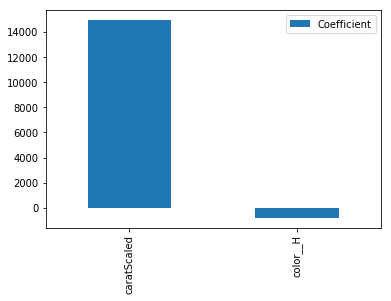

coefficients: [14949.30950735  -811.86943509]
intercept: -5906.910923839187
Mean squared error: 19120687.90
R2 Variance score: 0.74
       caratScaled  color__H
95968         0.62         0
18173         0.30         0
        actual      predict         diff       diff%
95968     2703  3361.660971  -658.660971   24.367775
18173      712 -1422.118072  2134.118072  299.735684
43632      861 -1337.028936  2198.028936  255.287914
8241       456 -1422.118072  1878.118072  411.867998
109702    3825  7547.467633 -3722.467633   97.319415
17779      535 -1422.118072  1957.118072  365.816462
39020      691  -824.145691  1515.145691  219.268552
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7438368956968108


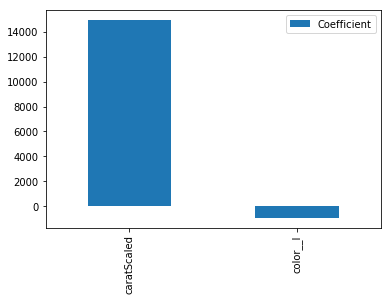

coefficients: [14926.04189428  -943.12924158]
intercept: -5881.1977126843685
Mean squared error: 19125110.33
R2 Variance score: 0.74
       caratScaled  color__I
95968         0.62         0
18173         0.30         0
        actual      predict         diff       diff%
95968     2703  3372.948262  -669.948262   24.785359
18173      712 -1403.385144  2115.385144  297.104655
43632      861  -507.822631  1368.822631  158.980561
8241       456 -1403.385144  1859.385144  407.759900
109702    3825  6609.110751 -2784.110751   72.787209
17779      535 -1403.385144  1938.385144  362.314980
39020      691  -806.343469  1497.343469  216.692253
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7456433632242074


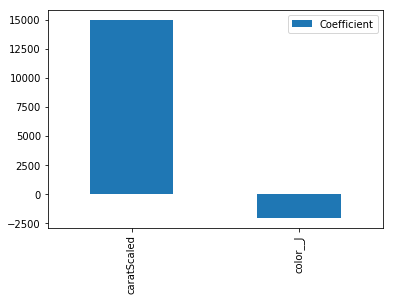

coefficients: [14977.41562976 -2038.09097887]
intercept: -5890.191386365224
Mean squared error: 18990239.65
R2 Variance score: 0.75
       caratScaled  color__J
95968         0.62         0
18173         0.30         0
        actual      predict         diff       diff%
95968     2703  3395.806304  -692.806304   25.631014
18173      712 -1396.966697  2108.966697  296.203188
43632      861  -498.321760  1359.321760  157.877092
8241       456 -1396.966697  1852.966697  406.352346
109702    3825  7589.482680 -3764.482680   98.417848
17779      535 -1396.966697  1931.966697  361.115271
39020      691  -797.870072  1488.870072  215.466002
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7446915059481959


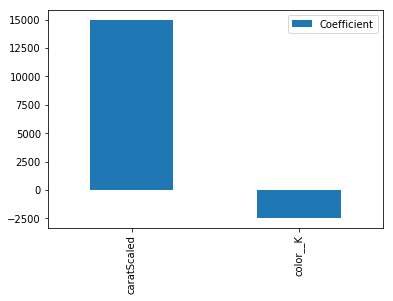

coefficients: [14959.04477104 -2474.78491334]
intercept: -5939.7768355353255
Mean squared error: 19061305.21
R2 Variance score: 0.74
       caratScaled  color__K
95968         0.62         0
18173         0.30         0
        actual      predict         diff       diff%
95968     2703  3334.830923  -631.830923   23.375173
18173      712 -1452.063404  2164.063404  303.941489
43632      861  -554.520718  1415.520718  164.404265
8241       456 -1452.063404  1908.063404  418.434957
109702    3825  7523.363458 -3698.363458   96.689241
17779      535 -1452.063404  1987.063404  371.413720
39020      691  -853.701613  1544.701613  223.545820
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7453332034525654


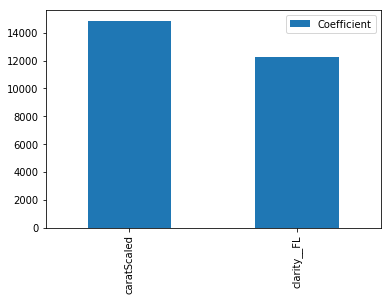

coefficients: [14865.19663664 12269.76823115]
intercept: -5991.277069701906
Mean squared error: 19013396.15
R2 Variance score: 0.75
       caratScaled  clarity__FL
95968         0.62            0
18173         0.30            0
        actual      predict         diff       diff%
95968     2703  3225.144845  -522.144845   19.317234
18173      712 -1531.718079  2243.718079  315.128944
43632      861  -639.806281  1500.806281  174.309673
8241       456 -1531.718079  1987.718079  435.903087
109702    3825  7387.399903 -3562.399903   93.134638
17779      535 -1531.718079  2066.718079  386.302445
39020      691  -937.110213  1628.110213  235.616529
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7446318785584661


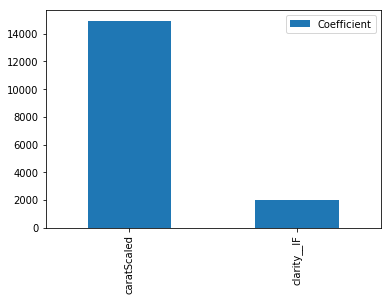

coefficients: [14941.78394411  1973.17526486]
intercept: -6093.889921563496
Mean squared error: 19065756.99
R2 Variance score: 0.74
       caratScaled  clarity__IF
95968         0.62            0
18173         0.30            0
        actual      predict         diff       diff%
95968     2703  3170.016124  -467.016124   17.277696
18173      712 -1611.354738  2323.354738  326.313868
43632      861  -714.847702  1575.847702  183.025285
8241       456 -1611.354738  2067.354738  453.367267
109702    3825  7353.715628 -3528.715628   92.254003
17779      535 -1611.354738  2146.354738  401.187802
39020      691 -1013.683381  1704.683381  246.698029
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7440131737315756


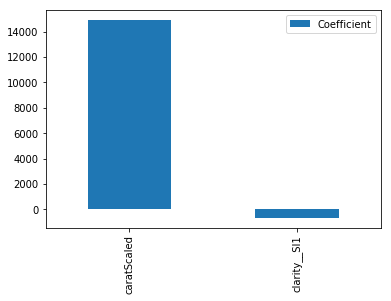

coefficients: [14900.92936714  -664.38665665]
intercept: -5819.893219286005
Mean squared error: 19111949.43
R2 Variance score: 0.74
       caratScaled  clarity__SI1
95968         0.62             0
18173         0.30             0
        actual      predict         diff       diff%
95968     2703  3418.682988  -715.682988   26.477358
18173      712 -1349.614409  2061.614409  289.552586
43632      861  -455.558647  1316.558647  152.910412
8241       456 -2014.001066  2470.001066  541.666900
109702    3825  7590.943211 -3765.943211   98.456032
17779      535 -1349.614409  1884.614409  352.264376
39020      691  -753.577234  1444.577234  209.056040
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7451873690665158


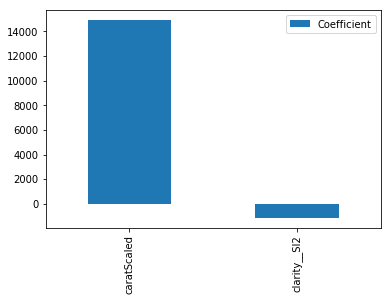

coefficients: [14904.86282048 -1147.62686772]
intercept: -5825.72072853371
Mean squared error: 19024284.13
R2 Variance score: 0.75
       caratScaled  clarity__SI2
95968         0.62             0
18173         0.30             0
        actual      predict         diff       diff%
95968     2703  3415.294220  -712.294220   26.351987
18173      712 -1354.261882  2066.261882  290.205321
43632      861  -459.970113  1320.970113  153.422777
8241       456 -1354.261882  1810.261882  396.987255
109702    3825  7588.655810 -3763.655810   98.396230
17779      535 -1354.261882  1889.261882  353.133062
39020      691  -758.067370  1449.067370  209.705842
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7429395392771037


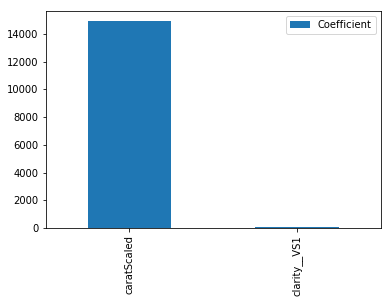

coefficients: [14923.72392745    70.84354036]
intercept: -6002.826123830084
Mean squared error: 19192106.86
R2 Variance score: 0.74
       caratScaled  clarity__VS1
95968         0.62             0
18173         0.30             0
        actual      predict         diff       diff%
95968     2703  3249.882711  -546.882711   20.232435
18173      712 -1525.708946  2237.708946  314.284964
43632      861  -630.285510  1491.285510  173.203892
8241       456 -1525.708946  1981.708946  434.585295
109702    3825  7428.525411 -3603.525411   94.209815
17779      535 -1525.708946  2060.708946  385.179242
39020      691  -928.759988  1619.759988  234.408103
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7430571753657276


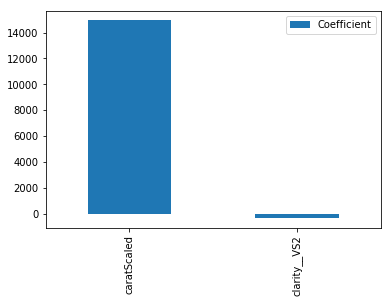

coefficients: [14931.43754473  -316.94835527]
intercept: -5943.282666009956
Mean squared error: 19183324.16
R2 Variance score: 0.74
       caratScaled  clarity__VS2
95968         0.62             0
18173         0.30             1
        actual      predict         diff       diff%
95968     2703  3314.208612  -611.208612   22.612231
18173      712 -1780.799758  2492.799758  350.112326
43632      861  -567.965150  1428.965150  165.965755
8241       456 -1463.851403  1919.851403  421.020044
109702    3825  7495.011124 -3670.011124   95.948003
17779      535 -1780.799758  2315.799758  432.859768
39020      691  -866.593901  1557.593901  225.411563
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7446809495688349


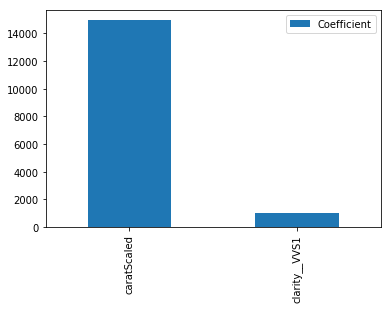

coefficients: [14937.20633999  1032.60222306]
intercept: -6130.082169088644
Mean squared error: 19062093.35
R2 Variance score: 0.74
       caratScaled  clarity__VVS1
95968         0.62              0
18173         0.30              0
        actual      predict         diff       diff%
95968     2703  3130.985762  -427.985762   15.833731
18173      712 -1648.920267  2360.920267  331.589925
43632      861  -752.687887  1613.687887  187.420196
8241       456 -1648.920267  2104.920267  461.605322
109702    3825  8346.005760 -4521.005760  118.196229
17779      535 -1648.920267  2183.920267  408.209396
39020      691   -18.829790   709.829790  102.725006
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64
Score:  0.7433263136869421


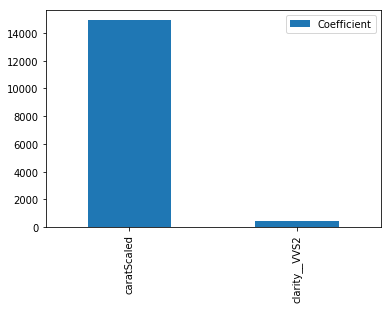

coefficients: [14921.24214567   440.62953466]
intercept: -6046.309181320808
Mean squared error: 19163230.33
R2 Variance score: 0.74
       caratScaled  clarity__VVS2
95968         0.62              1
18173         0.30              0
        actual      predict         diff       diff%
95968     2703  3645.490484  -942.490484   34.868312
18173      712 -1569.936538  2281.936538  320.496705
43632      861  -234.032474  1095.032474  127.181472
8241       456 -1569.936538  2025.936538  444.284328
109702    3825  7382.808750 -3557.808750   93.014608
17779      535 -1569.936538  2104.936538  393.446082
39020      691  -973.086852  1664.086852  240.822989
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64


In [109]:
columnSets = [ 'cut__Astor Ideal', 'cut__Good', 'cut__Ideal',
       'cut__Very Good', 'color__D', 'color__E', 'color__F', 'color__G',
       'color__H', 'color__I', 'color__J', 'color__K', 'clarity__FL',
       'clarity__IF', 'clarity__SI1', 'clarity__SI2', 'clarity__VS1',
       'clarity__VS2', 'clarity__VVS1', 'clarity__VVS2']

scores = {}
for c in columnSets:
    train1 = train[['caratScaled',c]]
    test1 = test[['caratScaled',c]]
    regr, score = run_linear3(train1, train_Y, test1, test_Y, log=True)
    scores[c] = score


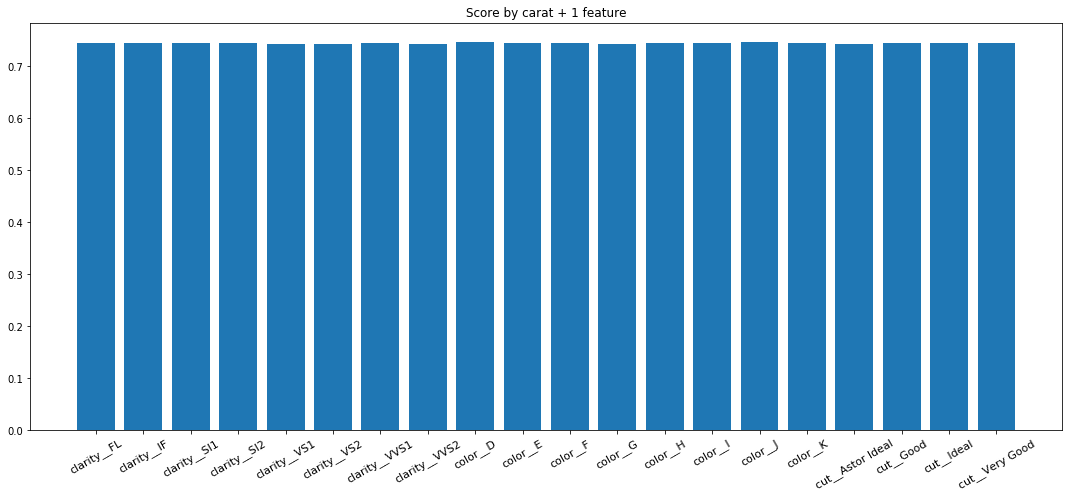

In [110]:
lists = sorted(scores.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_title('Score by carat + 1 feature')
fig.set_size_inches(18.5, 7.5)
plt.xticks(fontsize=11, rotation=30)
plt.show()

### 2-sets all produce about the same, .74 -- modest increase.

Next try adding each onehot group (all cuts, all colors, all clarities) and see how this works
One lesson learned is to avoid "[the dummy trap](https://www.algosome.com/articles/dummy-variable-trap-regression.html)" you need to leave out one of the one-hot combinations or you will either encounter a singularity problem (matrix inversion problem), or will wind up with whacko number as seen in this first example


Score:  0.7456586957875971


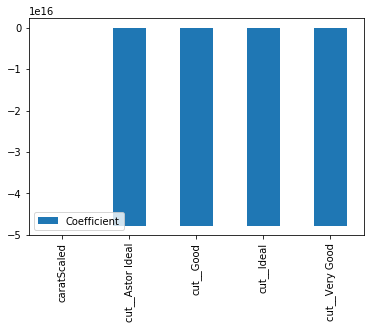

coefficients: [ 1.49318630e+04 -4.77733867e+16 -4.77733867e+16 -4.77733867e+16
 -4.77733867e+16]
intercept: 4.7773386742008456e+16
Mean squared error: 18989094.92
R2 Variance score: 0.75
       caratScaled  cut__Astor Ideal  cut__Good  cut__Ideal  cut__Very Good
95968         0.62                 0          0           0               1
18173         0.30                 0          0           0               1
        actual  predict    diff       diff%
95968     2703   2720.0   -17.0    0.628931
18173      712  -2056.0  2768.0  388.764045
43632      861   -424.0  1285.0  149.245064
8241       456  -1320.0  1776.0  389.473684
109702    3825   6904.0 -3079.0   80.496732
17779      535  -1320.0  1855.0  346.728972
39020      691   -720.0  1411.0  204.196816
count     35210.000000
mean       3771.394575
std        8640.718426
min         288.000000
25%         588.000000
50%        1243.000000
75%        3158.750000
max      176537.000000
Name: price, dtype: float64


In [111]:
columnSets = [['cut__Astor Ideal', 'cut__Good', 'cut__Ideal','cut__Very Good']]

scores = {}
for c in columnSets:
    f = ['caratScaled']+c
    train1 = train[f]
    test1 = test[f]
    regr, score = run_linear3(train1, train_Y, test1, test_Y, log=True)
    scores[c[0][:5]] = score

Notice above, the most important feature "Carat" still has a +weight but the other cut_ features have mega negative values (-e16.  The intercept is 4e16 and coefficient weights off the charts.   Net score is similar, but this yields wacky results.

Removing 1 of the onehots so the default is interpolated works (beyond my linear algebra  skills but see: https://www.algosome.com/articles/dummy-variable-trap-regression.html)


Score:  0.7456448374948172


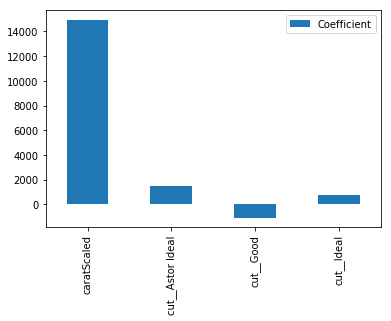

Score:  0.7541474695116475


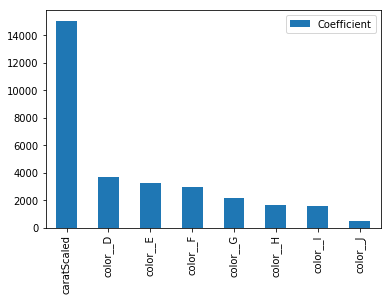

Score:  0.7518640446685683


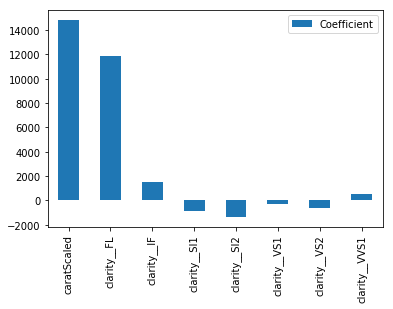

In [112]:
columnSets = [['cut__Astor Ideal', 'cut__Good', 'cut__Ideal',],
              ['color__D', 'color__E', 'color__F', 'color__G','color__H', 'color__I', 'color__J', ],
              ['clarity__FL','clarity__IF', 'clarity__SI1', 'clarity__SI2', 'clarity__VS1','clarity__VS2', 'clarity__VVS1', ]]

scores = {}
for c in columnSets:
    f = ['caratScaled']+c
    train1 = train[f]
    test1 = test[f]
    regr, score = run_linear3(train1, train_Y, test1, test_Y, log=False)
    scores[c[0][:5]] = score

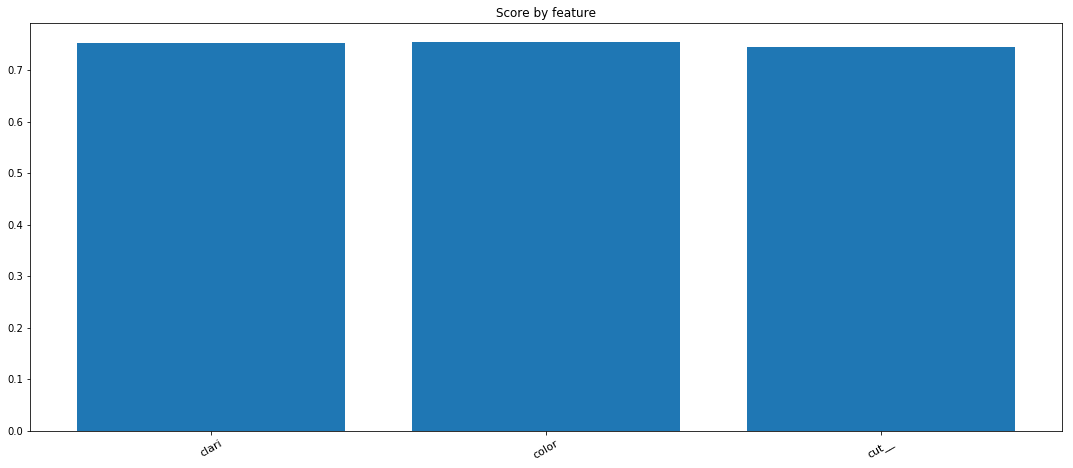

In [113]:
lists = sorted(scores.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_title('Score by feature')
fig.set_size_inches(18.5, 7.5)
plt.xticks(fontsize=11, rotation=30)
plt.show()


## Experiments 2 and 3 (2-sets and 3-sets)

Try all remaining combinations of columnSets: (c1+c2, c1+c3, c2+c3, c1+c2+c3) - same thing, strip the final onehot column to avoid the dummy trap

Score:  0.7561735919621706


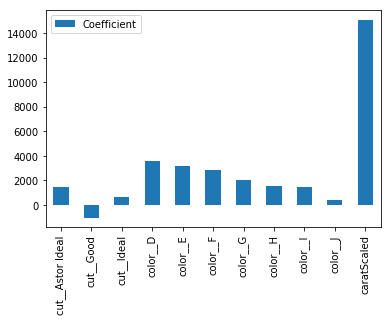

coefficients: [ 1429.29262522 -1024.58569218   639.79459866  3611.77968471
  3150.53394452  2819.21490551  2064.50983191  1578.669156
  1487.19902774   415.33443032 15076.21095413]
intercept: -8856.457398132929
Mean squared error: 18204053.89
R2 Variance score: 0.76
       cut__Astor Ideal  cut__Good  cut__Ideal  color__D  color__E  color__F  \
95968                 0          0           0         0         1         0   
18173                 0          0           0         0         1         0   

       color__G  color__H  color__I  color__J  caratScaled  
95968         0         0         0         0         0.62  
18173         0         0         0         0         0.30  
        actual      predict         diff       diff%
95968     2703  3641.327338  -938.327338   34.714293
18173      712 -1183.060167  1895.060167  266.160136
43632      861 -1210.557700  2071.557700  240.599036
8241       456  -543.265569   999.265569  219.137186
109702    3825  6199.331488 -2374.331488   6

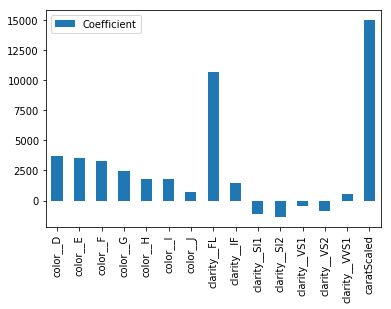

coefficients: [ 3703.71429016  3562.00738598  3248.74955246  2437.53455921
  1815.10508964  1756.72423771   665.59318985 10678.36486661
  1441.10665625 -1156.26291139 -1392.48686317  -478.74487272
  -863.23416014   574.90869953 15011.62439031]
intercept: -8139.846300429897
Mean squared error: 17665323.64
R2 Variance score: 0.76
       color__D  color__E  color__F  color__G  color__H  color__I  color__J  \
95968         0         1         0         0         0         0         0   
18173         0         1         0         0         0         0         0   

       clarity__FL  clarity__IF  clarity__SI1  clarity__SI2  clarity__VS1  \
95968            0            0             0             0             0   
18173            0            0             0             0             0   

       clarity__VS2  clarity__VVS1  caratScaled  
95968             0              0         0.62  
18173             1              0         0.30  
        actual      predict         diff       dif

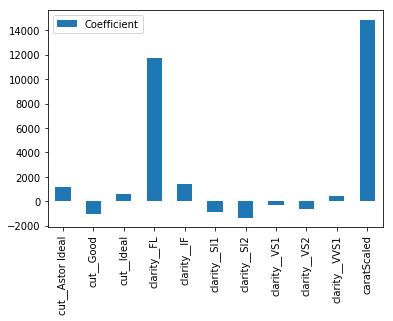

coefficients: [ 1198.85805583 -1015.08721695   602.79077081 11705.17924383
  1419.23769709  -875.90262893 -1326.22324367  -300.44330248
  -637.00248021   474.27177853 14852.83978281]
intercept: -6003.206935810838
Mean squared error: 18373267.17
R2 Variance score: 0.75
       cut__Astor Ideal  cut__Good  cut__Ideal  clarity__FL  clarity__IF  \
95968                 0          0           0            0            0   
18173                 0          0           0            0            0   

       clarity__SI1  clarity__SI2  clarity__VS1  clarity__VS2  clarity__VVS1  \
95968             0             0             0             0              0   
18173             0             0             0             1              0   

       caratScaled  
95968         0.62  
18173         0.30  
        actual      predict         diff       diff%
95968     2703  3205.553730  -502.553730   18.592443
18173      712 -2184.357481  2896.357481  406.791781
43632      861   -53.393843   914.39384

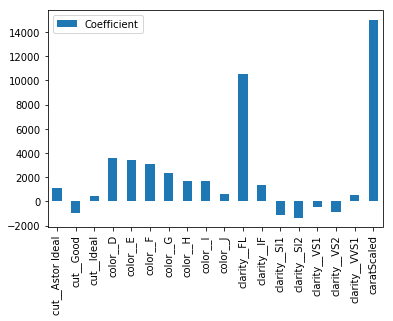

coefficients: [ 1122.35088004  -957.70046613   471.56252273  3604.24362627
  3443.65378177  3128.96414383  2340.71261083  1717.39519952
  1673.9767721    590.1060328  10566.54997464  1383.32878002
 -1131.5953868  -1340.53213295  -457.74564551  -848.77484115
   540.46973926 15014.89306894]
intercept: -8389.974398175218
Mean squared error: 17561025.09
R2 Variance score: 0.76
       cut__Astor Ideal  cut__Good  cut__Ideal  color__D  color__E  color__F  \
95968                 0          0           0         0         1         0   
18173                 0          0           0         0         1         0   

       color__G  color__H  color__I  color__J  clarity__FL  clarity__IF  \
95968         0         0         0         0            0            0   
18173         0         0         0         0            0            0   

       clarity__SI1  clarity__SI2  clarity__VS1  clarity__VS2  clarity__VVS1  \
95968             0             0             0             0              0 

In [114]:


cs = [['cut__Astor Ideal', 'cut__Good', 'cut__Ideal',],
              ['color__D', 'color__E', 'color__F', 'color__G','color__H', 'color__I', 'color__J',],
              ['clarity__FL','clarity__IF', 'clarity__SI1', 'clarity__SI2', 'clarity__VS1','clarity__VS2', 'clarity__VVS1', ]]

scores = {}
for c in [ cs[0]+cs[1], cs[1]+cs[2], cs[0]+cs[2], cs[0]+cs[1]+cs[2]]:
    train1 = train[c + ['caratScaled']]
    test1 = test[c + ['caratScaled']]
    regr, score = run_linear3(train1, train_Y, test1, test_Y, log=True)
    scores[str(c)] = score


## Score by Feature Groups?

[("['color__D', 'color__E', 'color__F', 'color__G', 'color__H', 'color__I', 'color__J', 'clarity__FL', 'clarity__IF', 'clarity__SI1', 'clarity__SI2', 'clarity__VS1', 'clarity__VS2', 'clarity__VVS1']", 0.7633893836043034), ("['cut__Astor Ideal', 'cut__Good', 'cut__Ideal', 'clarity__FL', 'clarity__IF', 'clarity__SI1', 'clarity__SI2', 'clarity__VS1', 'clarity__VS2', 'clarity__VVS1']", 0.7539071369801875), ("['cut__Astor Ideal', 'cut__Good', 'cut__Ideal', 'color__D', 'color__E', 'color__F', 'color__G', 'color__H', 'color__I', 'color__J', 'clarity__FL', 'clarity__IF', 'clarity__SI1', 'clarity__SI2', 'clarity__VS1', 'clarity__VS2', 'clarity__VVS1']", 0.7647863659190671), ("['cut__Astor Ideal', 'cut__Good', 'cut__Ideal', 'color__D', 'color__E', 'color__F', 'color__G', 'color__H', 'color__I', 'color__J']", 0.7561735919621706)]


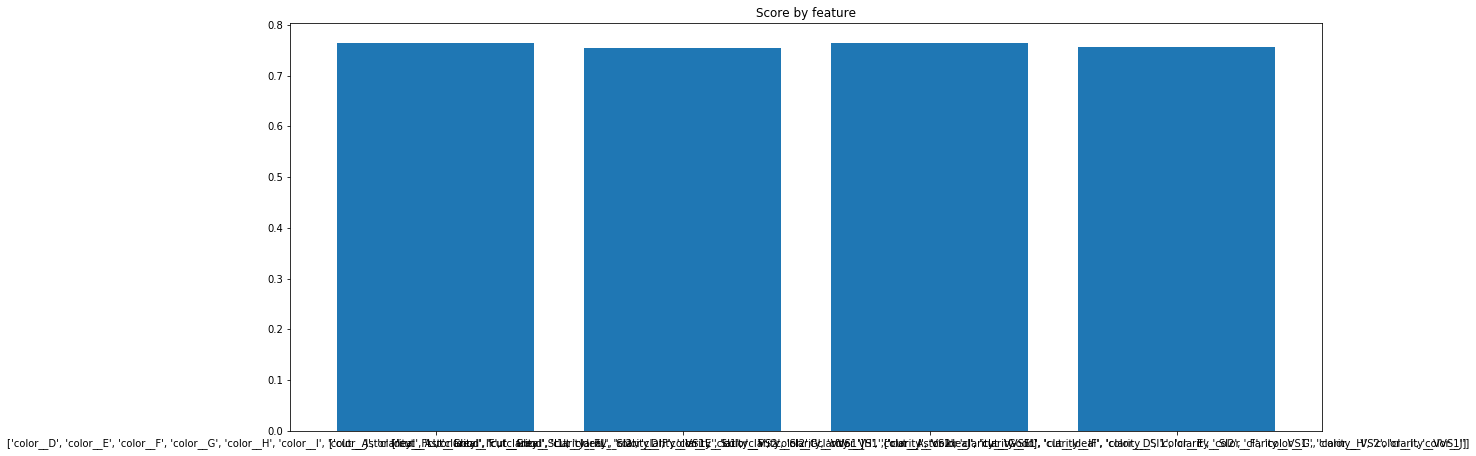

In [115]:
lists = sorted(scores.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_title('Score by feature')
fig.set_size_inches(18.5, 7.5)
#plt.xticks(fontsize=11, rotation=30)
print(lists)
plt.show()


### Not much difference, can get 0.01 increase to .76 if we leave out color but add the rest (3rd bar is Carat+Cut+Clarity)


### Try all 4 features again ?


Score:  0.7647863659190671


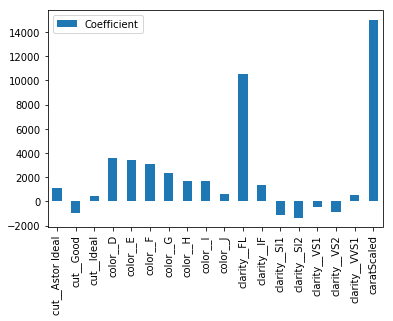

coefficients: [ 1122.35088004  -957.70046613   471.56252273  3604.24362627
  3443.65378177  3128.96414383  2340.71261083  1717.39519952
  1673.9767721    590.1060328  10566.54997464  1383.32878002
 -1131.5953868  -1340.53213295  -457.74564551  -848.77484115
   540.46973926 15014.89306894]
intercept: -8389.974398175218
Mean squared error: 17561025.09
R2 Variance score: 0.76
       cut__Astor Ideal  cut__Good  cut__Ideal  color__D  color__E  color__F  \
95968                 0          0           0         0         1         0   
18173                 0          0           0         0         1         0   

       color__G  color__H  color__I  color__J  clarity__FL  clarity__IF  \
95968         0         0         0         0            0            0   
18173         0         0         0         0            0            0   

       clarity__SI1  clarity__SI2  clarity__VS1  clarity__VS2  clarity__VVS1  \
95968             0             0             0             0              0 

Index(['cut__Astor Ideal', 'cut__Good', 'cut__Ideal', 'color__D', 'color__E',
       'color__F', 'color__G', 'color__H', 'color__I', 'color__J',
       'clarity__FL', 'clarity__IF', 'clarity__SI1', 'clarity__SI2',
       'clarity__VS1', 'clarity__VS2', 'clarity__VVS1', 'caratScaled'],
      dtype='object')

In [116]:
# all 4 features
c = cs[0]+cs[1]+cs[2]
train1 = train[c + ['caratScaled']]
test1 = test[c + ['caratScaled']]
regr_full, score = run_linear3(train1, train_Y, test1, test_Y, log=True)

print ('std regression score: ', score)
train1.columns



## Now try some other fancier linear models Experiements 4*,5,6

In [117]:
print('----ridge----')
from sklearn.linear_model import Ridge
import numpy as np
for a in [1.0,2.0,3.0,4.0,5.0,10.0,50.0, 200.0]:
    clf = Ridge(alpha=a)
    clf.fit(train1, train_Y)
    print(clf.score(test1, test_Y))

print('----lasso----')
from sklearn import linear_model
for a in [0.1,0.2,0.5,1.0,5.0, 20.0]:
    reg = linear_model.Lasso(alpha=a)
    reg.fit(train1, train_Y)
    print(reg.score(test1, test_Y))

    
print('----isotonic single var----')
from sklearn.datasets import make_regression
from sklearn.isotonic import IsotonicRegression
iso_reg = IsotonicRegression(y_min=500).fit(train1['caratScaled'], train_Y)
print(iso_reg.score(test1['caratScaled'], test_Y))


print('----elastic regular----')
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
regr = ElasticNet(random_state=0)
regr.fit(train1, train_Y)
print(regr.coef_) 
print(regr.intercept_) 
print(regr.score(test1, test_Y))


----ridge----
0.7647980624484217
0.7648095939542399
0.7648209627655458
0.7648321711731727
0.7648432214304914
0.7648961767964993
0.7652072156607489
0.7655013335494227
----lasso----
0.7648009114679913
0.7648148850622719
0.764853363618521
0.7649060833790738
0.7650595630095605
0.7638751792386795
----isotonic single var----
0.8216663345408373
----elastic regular----
[  17.54819301  -74.90785325  225.55767821  316.15253311   53.85199663
   27.22427761  -30.91027971  -24.26739498 -157.30783384 -106.08611653
   98.76272638  112.4508695  -325.59077566 -295.24589447  167.09014517
  -27.58167563  122.7208604  5215.74898362]
280.6551527495508
0.44399596294393


In [118]:
## random forests

from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(max_depth=2, random_state=8, n_estimators=100)
rfr.fit(train1, train_Y)  

print('Score: ', rfr.score(test1, test_Y))
print(rfr.feature_importances_)
print(rfr.predict(test1))

Score:  0.7949120470998488
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1247.08718316 1247.08718316 1247.08718316 ... 1247.08718316 7216.08000357
 1247.08718316]


Vary the learning rate
Score:  0.5728005903433654
Score:  0.8197595414338851
Score:  0.8327162140261575
Score:  0.8362673929564592
Score:  0.8342543441152889
Score:  0.8351180089931884
Vary the estimators
Score:  0.5843056350524515
Score:  0.8203966260446274
Score:  0.8327162140261575
Score:  0.8362025170592737
Score:  0.839496652289263
Score:  0.8391997884612116
Vary the depth
Score:  0.8327162140261575
Score:  0.9143609385924006
Score:  0.942176557737864
Score:  0.9504495195879945
Score:  0.9515768570482609
Score:  0.9515768570482609


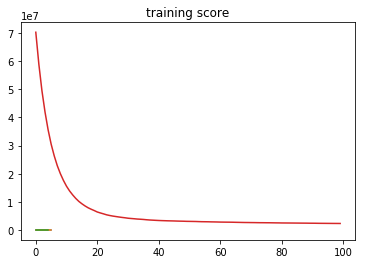

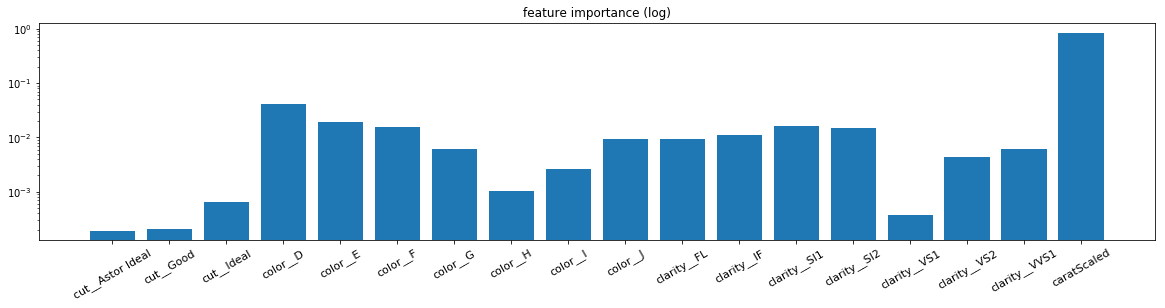

0.9515768570482609
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=8, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)


In [119]:
## xgboost !

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

def run_emsemble(X_train, y_train, X_test, y_test, norm=True, lr=0.1, ne=100, md=1, g=True):
    est = GradientBoostingRegressor(n_estimators=ne, learning_rate=lr,
        max_depth=md, random_state=8, loss='ls').fit(X_train, y_train)
    score = est.score(X_test, y_test)
    print('Score: ',score)
    mean_squared_error(y_test, est.predict(X_test))    

    if (g):
        plt.plot(est.train_score_)
        plt.title('training score')
        plt.show()

        index = np.arange(len(est.feature_importances_))
        plt.figure(figsize=(20,4))
        plt.bar(index, est.feature_importances_)
        plt.title('feature importance (log)')
        plt.xticks(index, X_test.columns, fontsize=11, rotation=30)
        plt.yscale('log')
        plt.show()

    return score,est

print('Vary the learning rate')
scores = []
for i in [0.01, 0.05, 0.1, 0.2, 0.4, 0.8]:
    scores.append(run_emsemble(train1, train_Y, test1, test_Y, True, i, 100, 1, False)[0])
plt.plot(scores)

print('Vary the estimators')
scores = []
for i in [10, 50, 100, 150, 300, 1000]:
    scores.append(run_emsemble(train1, train_Y, test1, test_Y, True, 0.1, i, 1, False)[0])
plt.plot(scores)

print('Vary the depth')
scores = []
for i in [1,2,3,4,5]:
    scores.append(run_emsemble(train1, train_Y, test1, test_Y, True, 0.1, 100, i, False)[0])
plt.plot(scores)

# depth 5 gets .95 score !
score, model = run_emsemble(train1, train_Y, test1, test_Y, True, 0.1, 100, 5, True)
print(score)
print(model)


## Saving the models for AzureML


In [120]:
from sklearn.externals import joblib
import os

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=models['carat'], filename='outputs/sklearn_diamond_simple_model.pkl')
joblib.dump(value=models['caratScaled'], filename='outputs/sklearn_diamond_simple2_model.pkl')
joblib.dump(value=regr_full, filename='outputs/sklearn_diamond_regr_model.pkl')
joblib.dump(value=model, filename='outputs/sklearn_diamond_xgb_model.pkl')
joblib.dump(value=rfr, filename='outputs/sklearn_diamond_randomforest_model.pkl')
joblib.dump(value=iso_reg, filename='outputs/sklearn_diamond_isoridgelineartreg_model.pkl')

print('done')



done
